# Classificação de sequencias

In [ ]:
import os, random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

import torch
from torch import nn, optim
from torchtext import data
from torchtext import datasets
import torch.nn.functional as F
import spacy
from spacy.cli import download as spacy_download
import subprocess
import sys

SEED = 1234
torch.manual_seed(SEED)

tokenizer_language='en_core_web_sm'

def ensure_spacy_model(model_name, version='3.7.1'):
    try:
        spacy.load(model_name)
    except OSError:
        try:
            spacy_download(model_name)
        except SystemExit:
            wheel_url = (
                f'https://github.com/explosion/spacy-models/releases/download/'
                f'{model_name}-{version}/{model_name}-{version}-py3-none-any.whl'
            )
            print(f'Baixando modelo spaCy diretamente: {wheel_url}')
            try:
                subprocess.check_call([sys.executable, '-m', 'pip', 'install', wheel_url])
            except subprocess.CalledProcessError as err:
                raise RuntimeError(f'Falha ao instalar {model_name} via pip: {err}')
        spacy.load(model_name)

ensure_spacy_model(tokenizer_language)

num_cores = max(1, (os.cpu_count() or 1))
torch.set_num_threads(num_cores)
torch.set_num_interop_threads(1)
os.environ['OMP_NUM_THREADS'] = str(num_cores)
os.environ['MKL_NUM_THREADS'] = str(num_cores)
os.environ['OPENBLAS_NUM_THREADS'] = str(num_cores)
torch.backends.mkldnn.enabled = True
print(f'Threads intra-op: {torch.get_num_threads()} | inter-op: {torch.get_num_interop_threads()}')

# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')
print(device)


/home/carloslessa/FCD/Alura/deep-learning-pytorch/rn-recorrentes/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Threads intra-op: 16 | inter-op: 1
cpu


## IMDb Reviews


<img src="imdb_reviews.png" width="700">


## Torchtext

Similar ao torchvision para imagens, o pacote torchtext facilita o trabalho com texto, oferecendo ferramentas aproveitáveis para outros dados sequenciais.

Um dos seus principais elementos é o `Field`, objeto que carrega informações de como os dados devem ser processados. 

No nosso caso temos dois dados:
* Texto: Uma sequência de caracteres que será dividida em **tokens**. Armazenaremos também os tamanhos das frases pois mais a frente veremos como trabalhar com sequências de tamanhos variáveis

  * Ex: "Bom dia Brasil!" $\rightarrow$ `["bom", "dia", "brasil", "!"]`

```python
TEXT = data.Field(tokenize = 'spacy', include_lengths = True)
```

* Label: Categorias descritas como "pos" e "neg". Essas serão transformadas para valores numéricos {neg: 0, pos: 1}

```python
LABEL = data.LabelField(dtype = torch.long)
```



In [2]:
TEXT = data.Field(tokenize = 'spacy', include_lengths = True, tokenizer_language='en_core_web_sm')
LABEL = data.LabelField(dtype = torch.long)

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [3]:
for sample in valid_data:
  
  print(vars(sample))
  
  texto = sample.text
  label = sample.label

  break

{'text': ['A', 'long', '-', 'defunct', 'prison', ',', 'shut', 'down', 'for', 'over', '20', 'years', ',', 'is', 're', '-', 'opened', 'and', 'Ethan', 'Sharpe', '(', 'the', 'late', ',', 'great', 'character', 'actor', 'Lane', 'Smith', ')', ',', 'once', 'a', 'guard', 'there', ',', 'is', 'put', 'in', 'place', 'as', 'warden', '.', 'As', 'the', 'prisoners', 'are', 'put', 'to', 'work', 'fixing', 'the', 'place', 'up', ',', 'they', "'re", 'instructed', 'to', 'break', 'into', 'the', 'old', 'execution', 'room', '.', 'This', 'unleashes', 'a', 'fierce', 'spirit', 'that', 'wreaks', 'merciless', 'havoc', 'upon', 'both', 'guards', 'and', 'prisoners', ';', 'cool', '-', 'as', '-', 'can', '-', 'be', 'low', '-', 'key', 'prisoner', 'Burke', '(', 'Viggo', 'Mortensen', ',', 'showing', 'real', 'poise', 'in', 'an', 'early', 'role', ')', 'is', 'thrust', 'into', 'the', 'role', 'of', 'hero.<br', '/><br', '/>I', 'know', 'it', "'s", 'a', 'no', '-', 'brainer', 'to', 'praise', 'the', 'film', 'for', 'its', 'atmosphere',

## Representação do Dado


### Vocabulário

Uma pergunta que pode ter passado na sua cabeça: como alimentamos uma rede neural com palavras de um texto?

Para transformar palavras em dados numéricos, a solução mais simples é mapeá-las em um dicionário contendo o vocabulário completo do conjunto. 

<img src="https://static.packt-cdn.com/products/9781786465825/graphics/B05525_03_01.jpg" width="500">

Podemos fazer isso chamando a função **```build_vocab```** nos nossos fields. Como datasets de texto podem chegar a centenas de milhares de palavras, é importante definir um limite superior para o número de palavras mapeadas pelo dicionário. No código a seguir, esse limite é definido como ```MAX_VOCAB_SIZE = 25000```

Atenção também para o parâmetro ```vectors = "glove.6B.100d"```. O GloVe (Global Vectors) é um método de representação de palavras que explicaremos em maiores detalhes mais a frente. A princípio basta saber que o modelo "glove.**6B**.**100d**" foi treinado em **6 bilhões** de tokens e gera uma representação latente de dimensionalidade  **d = 100**

In [4]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

In [5]:
print('Tamanho do vocabulario', len(TEXT.vocab),'\n')
print(TEXT.vocab.itos[:10],'\n', LABEL.vocab.stoi, '\n')
TEXT.vocab.freqs.most_common(20)

Tamanho do vocabulario 25002 

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is'] 
 defaultdict(None, {'neg': 0, 'pos': 1}) 



[('the', 202265),
 (',', 192856),
 ('.', 165703),
 ('and', 109310),
 ('a', 109266),
 ('of', 100544),
 ('to', 93539),
 ('is', 76230),
 ('in', 61314),
 ('I', 54374),
 ('it', 53662),
 ('that', 49248),
 ('"', 44431),
 ("'s", 43509),
 ('this', 42411),
 ('-', 37336),
 ('was', 35339),
 ('/><br', 35320),
 ('as', 30359),
 ('with', 29900)]

### Embedding Layer

Documentação Pytorch: https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding

Camadas de embedding são treinadas para mapear um ínidice numérico para um vetor denso de maior carga semântica.

Acabamos de ver a representação de palaras como ínidices de um vocabulário fixo. Apesar do índice informar a qual palavra estamos nos referindo, ele não incorpora nenhuma informação semântica sobre a palavra. O treinamento de embeddings para dados textuais tem como objetivo projetar esses índices em um espaço onde palavras semanticamente similares estejam próximas.

![](https://drive.google.com/uc?export=view&id=1pliMSOcjjOZAiR26ycowSeUJsj5cy9W_)

No Pytorch, a instância dessa classe recebe como parâmetro ```(vocab_size, embedding_size, padding_idx)```
* ```vocab_size```: Tamanho do vocabulário. Note que **não** se trata da dimensionalidade da entrada.
* ```embedding_size```: Dimensionalidade da dimensão latente. Caso haja o aproveitamento de embeddings pré treinadas deve-se definir a dimensionalidade da camada em função dos pesos que serão importados (ex: glove.6b.100d, ```embedding_size=100```).


In [6]:
class RNN(nn.Module):
  
  def __init__(self, tam_vocab, tam_embedding, embed_vectors, 
               ind_unk, ind_pad):
    super(RNN, self).__init__()

    # Inicializaremos a camada de embedding
    self.embedding = nn.Embedding(tam_vocab, tam_embedding)
    self.embedding.weight.data.copy_(embed_vectors)
    self.embedding.weight.data[ind_unk] = torch.zeros(tam_embedding)
    self.embedding.weight.data[ind_pad] = torch.zeros(tam_embedding)
    #######################################


  def forward(self, X):
    vectors = self.embedding(X)


tam_vocab = len(TEXT.vocab)
tam_embedding = 100 # glove 100d
embed_vectors = TEXT.vocab.vectors
ind_pad = TEXT.vocab.stoi[TEXT.pad_token]
ind_unk = TEXT.vocab.stoi[TEXT.unk_token]

model = RNN(tam_vocab, tam_embedding, embed_vectors, 
               ind_unk, ind_pad)

print(model)

RNN(
  (embedding): Embedding(25002, 100)
)


## BucketIterator
Essa classe do Torchtext funciona de forma análoga ao DataLoader do PyTorch,  porém leva em consideração a construção de **batches com sequências de comprimento variável**. Internamente ele agrega sequências de comprimento similar, **minimizando a quantidade de padding necessária**. 

Além disso, os dados já saem preparados para serem empacotados pela função ```pack_padded_sequence``` ordenados por comprimento de sequência e informando o comprimento real de cada amostra (sem padding).

> Exemplo: Para compor um tensor com 5 amostras de frases com tamanhos variáveis, a segunda dimensão é definida pela frase de maior comprimento. Amostras menores são complementadas com tokens nulos (`<pad>`). 

<img src="bucket_iterator.png" width="450">


Documentação: https://torchtext.readthedocs.io/en/latest/data.html?highlight=BucketIterator#torchtext.data.BucketIterator


In [7]:
BATCH_SIZE = 64

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

In [8]:
for sample in valid_iterator:

  texto, tamanho = sample.text
  label = sample.label
  
  print(f'Texto: {texto.shape}, Tamanho: {tamanho.shape}, Label: {label.shape} \n', )

  print(tamanho)

  break

Texto: torch.Size([48, 64]), Tamanho: torch.Size([64]), Label: torch.Size([64]) 

tensor([48, 47, 47, 47, 47, 47, 46, 46, 46, 46, 46, 46, 46, 46, 45, 45, 45, 45,
        44, 44, 44, 44, 44, 43, 43, 43, 42, 42, 42, 42, 42, 41, 41, 41, 41, 41,
        40, 40, 40, 40, 40, 40, 39, 39, 38, 38, 38, 38, 37, 36, 36, 36, 35, 35,
        35, 34, 33, 33, 32, 32, 27, 24, 22, 13])


## Padding and Packing (Preenchendo e empacotando)

O pacote de funções de rnn, ```nn.utils.rnn```, oferece meios de processar batches contendo sequências de tamanho variável. Isso é realizado através do **padding** da sequência (ex: preenchimento com zeros),  de modo que elas aparentem ter igual comprimento, porém internamente as posições preenchidas não são processadas pela RNN.

*  Vamos lembrar do nosso batch de frases com tamanhos variáveis:

<img src="bucket_iterator.png" width="450">


*  O empacotamento precisa receber os dados em ordem decrescente de comprimento, e internamente são criados "mini batches" com o seu batch. Dessa forma, apenas os timesteps que contém informação relevante sobre o dado são apresentadas à rede. Igualmente, somente esses timesteps impactam no backpropagation.

<img src="bucket_iterator2.png" width="450">


Para isso basta realizar o padding das suas sequências, **preservando os comprimetos originais** em outra variável. Na prática, o forward recebe mais um parâmetro, aqui chamamos de **```tamanhos```**, referente ao comprimento de cada amostra dentro do batch **```X```**, ordenado de forma descrescente.

Tendo em mãos (1) o batch de sequências preenchidas e ordenadas, e (2) o comprimento original de cada amostra, basta realizar as seguintes operações no forward da rede:

```python
## Empacote a sequência antes de alimentar a unidade recorrente
packed_input = nn.utils.rnn.pack_padded_sequence(X, tamanhos)

## Forward recorrente
packed_output, hidden = self.rnn(packed_input, hidden )

## Desempacote a sequência para continuar o fluxo na rede.
output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
```

In [9]:
class RNN(nn.Module):
  
  def __init__(self, tam_vocab, tam_embedding, embed_vectors, 
               ind_unk, ind_pad, hidden_size):
    super(RNN, self).__init__()

    # Inicializaremos a camada de embedding
    self.embedding = nn.Embedding(tam_vocab, tam_embedding)
    self.embedding.weight.data.copy_(embed_vectors)
    self.embedding.weight.data[ind_unk] = torch.zeros(tam_embedding)
    self.embedding.weight.data[ind_pad] = torch.zeros(tam_embedding)
    #######################################

    # Camada recorrente
    self.hidden_size = hidden_size
    self.rnn = nn.GRU(tam_embedding, hidden_size)


  def forward(self, X, tamanhos):
    print('X:', X.size(), '\n')
    print('tamanhos', tamanhos, '\n')
    vectors = self.embedding(X)
    print('Vectors:', vectors.size(), '\n')

    hidden = torch.randn(1, X.size(1), self.hidden_size)

    ## Empacote a sequência antes de alimentar a unidade recorrente
    packed_input = nn.utils.rnn.pack_padded_sequence(vectors, tamanhos)
    print('Packed input:', packed_input.batch_sizes, '\n')
    
    ## Forward recorrente
    packed_output, hidden = self.rnn(packed_input, hidden )
    print('Packed output:', packed_output.batch_sizes, '\n')

    ## Desempacote a sequência para continuar o fluxo na rede.
    output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
    print('output:', output.size(), '\n')

    return output


tam_vocab = len(TEXT.vocab)
tam_embedding = 100 # glove 100d
embed_vectors = TEXT.vocab.vectors
ind_pad = TEXT.vocab.stoi[TEXT.pad_token]
ind_unk = TEXT.vocab.stoi[TEXT.unk_token]

hidden_size = 256

model = RNN(tam_vocab, tam_embedding, embed_vectors, 
               ind_unk, ind_pad, hidden_size)

print(model)

RNN(
  (embedding): Embedding(25002, 100)
  (rnn): GRU(100, 256)
)


In [10]:
for sample in valid_iterator:
  texto, tamanhos = sample.text
  label = sample.label

  saida = model(texto, tamanhos)
  break

X: torch.Size([48, 64]) 

tamanhos tensor([48, 47, 47, 47, 47, 47, 46, 46, 46, 46, 46, 46, 46, 46, 45, 45, 45, 45,
        44, 44, 44, 44, 44, 43, 43, 43, 42, 42, 42, 42, 42, 41, 41, 41, 41, 41,
        40, 40, 40, 40, 40, 40, 39, 39, 38, 38, 38, 38, 37, 36, 36, 36, 35, 35,
        35, 34, 33, 33, 32, 32, 27, 24, 22, 13]) 

Vectors: torch.Size([48, 64, 100]) 

Packed input: tensor([64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 63, 63, 63, 63, 63,
        63, 63, 63, 63, 62, 62, 61, 61, 61, 60, 60, 60, 60, 60, 58, 56, 55, 52,
        49, 48, 44, 42, 36, 31, 26, 23, 18, 14,  6,  1]) 

Packed output: tensor([64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 63, 63, 63, 63, 63,
        63, 63, 63, 63, 62, 62, 61, 61, 61, 60, 60, 60, 60, 60, 58, 56, 55, 52,
        49, 48, 44, 42, 36, 31, 26, 23, 18, 14,  6,  1]) 

output: torch.Size([48, 64, 256]) 



## Classificando Sequências


In [11]:
class RNN(nn.Module):
  
  def __init__(self, tam_vocab, tam_embedding, embed_vectors, 
               ind_unk, ind_pad, hidden_size, output_size):
    super(RNN, self).__init__()

    # Inicializaremos a camada de embedding
    self.embedding = nn.Embedding(tam_vocab, tam_embedding)
    self.embedding.weight.data.copy_(embed_vectors)
    self.embedding.weight.data[ind_unk] = torch.zeros(tam_embedding)
    self.embedding.weight.data[ind_pad] = torch.zeros(tam_embedding)
    #######################################

    self.hidden_size = hidden_size
    self.rnn = nn.GRU(tam_embedding, hidden_size)
    self.linear = nn.Linear(hidden_size, output_size)


  def forward(self, X, tamanhos):
    vectors = self.embedding(X)

    hidden = torch.zeros(1, X.size(1), self.hidden_size).to(device)

    packed_input = nn.utils.rnn.pack_padded_sequence(vectors, tamanhos)
    packed_output, hidden = self.rnn(packed_input, hidden )
    output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
    
    # print('output:', output.size())
    output = F.adaptive_max_pool1d(output.permute(1,2,0), 1)
    # print('output pool:', output.size())
    output = self.linear(output.squeeze())
    # print('output linear:', output.size())

    return output


tam_vocab = len(TEXT.vocab)
tam_embedding = 100 # glove 100d
embed_vectors = TEXT.vocab.vectors
ind_pad = TEXT.vocab.stoi[TEXT.pad_token]
ind_unk = TEXT.vocab.stoi[TEXT.unk_token]

hidden_size = 256
output_size = 2

model = RNN(tam_vocab, tam_embedding, embed_vectors, 
               ind_unk, ind_pad, hidden_size, output_size)

model = model.to(device)

print(model)

RNN(
  (embedding): Embedding(25002, 100)
  (rnn): GRU(100, 256)
  (linear): Linear(in_features=256, out_features=2, bias=True)
)


In [12]:
for sample in valid_iterator:
  texto, tamanhos = sample.text
  label = sample.label

  saida = model(texto, tamanhos.cpu())
  break

### Loss e Otimizador

In [13]:
criterio = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-5)

In [14]:
def forward(iterator, num_samples, etapa):
  if etapa == 'Treino': model.train()
  else: model.eval()

  acuracia = 0.
  loss_epoca = []
  for k, sample in enumerate(iterator):
      
    texto, tamanhos = sample.text
    rotulo = sample.label

    saida = model(texto, tamanhos.cpu())

    loss = criterio(saida, rotulo)
    loss_epoca.append(loss.detach().cpu().numpy())

    _, pred = torch.max(saida, axis=-1)
    acuracia += (pred.cpu().data == rotulo.cpu().data).sum()
    
    if etapa == 'Treino':
      # Otimização
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  loss_epoca = np.asarray(loss_epoca).ravel()
  acuracia   = acuracia/float(num_samples)
  print('\n','*'*15 + etapa + '*'*15 )
  print('Epoca: {:}, Loss: {:.4f} +/- {:.4f}, Acurácia: {:.4f}'.format(epoca, loss_epoca.mean(), 
                                                                        loss_epoca.std(), 
                                                                        acuracia
                                                                       )) 
  return loss_epoca.mean(), acuracia

In [15]:
loss_treino, loss_test = [], []
acc_treino, acc_test = [], []

for epoca in range(25):
  loss, acuracia = forward(train_iterator, len(train_data), 'Treino')
  loss_treino.append(loss)
  acc_treino.append(acuracia)  

  loss, acuracia = forward(valid_iterator, len(valid_data), 'Teste')
  loss_test.append(loss)
  acc_test.append(acuracia)



 ***************Treino***************
Epoca: 0, Loss: 0.6824 +/- 0.0125, Acurácia: 0.5803

 ***************Teste***************
Epoca: 0, Loss: 0.6610 +/- 0.0143, Acurácia: 0.6415

 ***************Treino***************
Epoca: 1, Loss: 0.5729 +/- 0.0651, Acurácia: 0.7085

 ***************Teste***************
Epoca: 1, Loss: 0.5151 +/- 0.0489, Acurácia: 0.7548

 ***************Treino***************
Epoca: 2, Loss: 0.4834 +/- 0.0635, Acurácia: 0.7754

 ***************Teste***************
Epoca: 2, Loss: 0.4567 +/- 0.0654, Acurácia: 0.7893

 ***************Treino***************
Epoca: 3, Loss: 0.4351 +/- 0.0699, Acurácia: 0.8046

 ***************Teste***************
Epoca: 3, Loss: 0.4399 +/- 0.0714, Acurácia: 0.7980

 ***************Treino***************
Epoca: 4, Loss: 0.3933 +/- 0.0728, Acurácia: 0.8285

 ***************Teste***************
Epoca: 4, Loss: 0.4107 +/- 0.0687, Acurácia: 0.8136

 ***************Treino***************
Epoca: 5, Loss: 0.3715 +/- 0.0685, Acurácia: 0.8398

 **

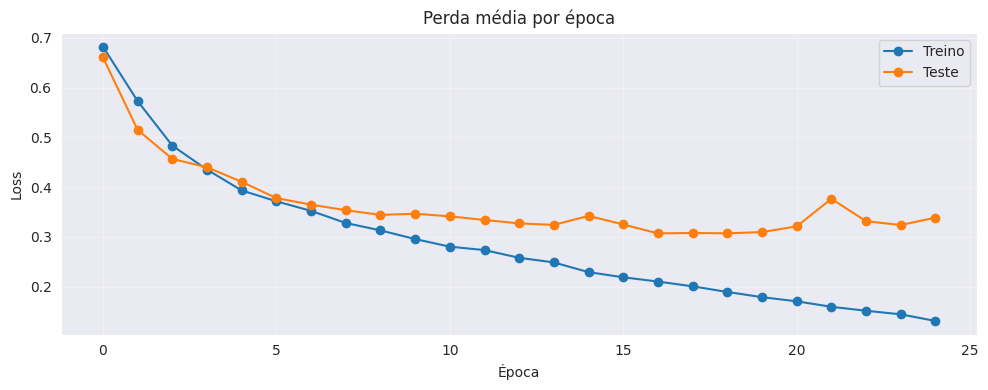

In [24]:
# Gráfico das perdas de treino e validação.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(loss_treino, label='Treino', marker='o')
plt.plot(loss_test, label='Teste', marker='o')
plt.title('Perda média por época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

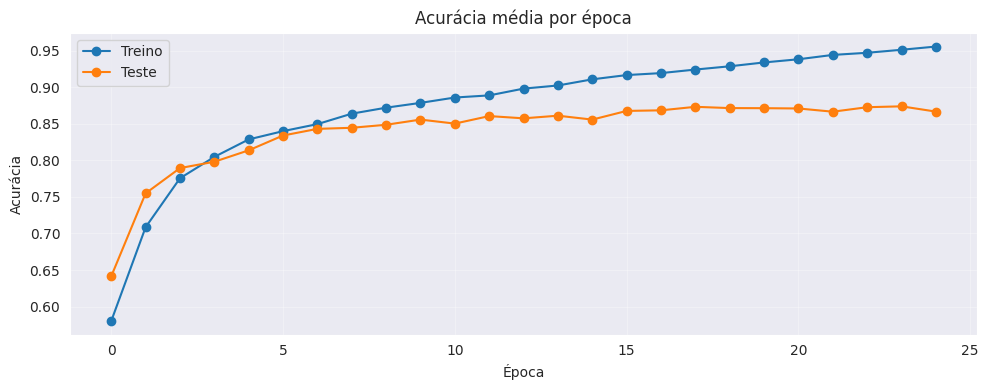

In [25]:
# Gráfico das acurácias de treino e validação.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(acc_treino, label='Treino', marker='o')
plt.plot(acc_test, label='Teste', marker='o')
plt.title('Acurácia média por época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
import spacy
nlp = spacy.load('en_core_web_sm')

def predict_sentiment(sentence):
    model.eval()
    tokenized = [str(tok) for tok in nlp.tokenizer(sentence)]
    print(tokenized)

    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    print(indexed)
    
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    
    prediction = model(tensor, length_tensor)
    
    return F.softmax(prediction, dim=-1).cpu().data

['After', 'reading', 'Fool', 'For', 'Love', 'in', 'a', 'Drama', 'class', 'of', 'mine', ',', 'I', 'was', 'looking', 'forward', 'to', 'seeing', 'how', 'Sam', 'Shepard', "'s", 'wonderful', 'play', 'would', 'be', 'translated', 'to', 'the', 'screen', '.', 'Much', 'to', 'my', 'dismay', ',', 'it', 'was', 'nowhere', 'near', 'as', 'entertaining', 'as', 'the', 'play', '.', 'The', 'film', 'seemed', 'to', 'drag', ',', 'the', 'music', 'was', 'inappropriate', 'for', 'the', 'tone', 'of', 'the', 'movie', ',', 'and', 'all', 'the', 'raw', 'energy', 'of', 'the', 'play', 'seemed', 'to', 'have', 'been', 'sucked', 'out', 'of', 'this', 'film', 'version', '.', 'It', "'s", 'a', 'shame', 'to', 'see', 'this', 'come', 'out', 'this', 'way', 'even', 'with', 'Shepard', "'s", 'involvement', ',', 'playing', 'the', 'role', 'of', 'Eddie', '.', 'Do', 'yourselves', 'a', 'favor', '...', 'see', 'the', 'play', 'next', 'time', 'it', "'s", 'being', 'performed', 'in', 'your', 'area', 'or', 'simply', 'read', 'the', 'book', 'inst

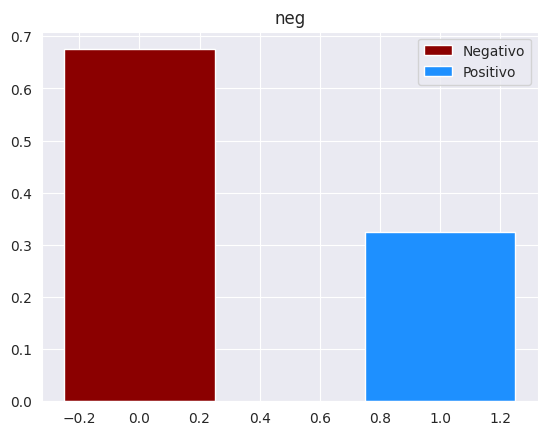

['Like', 'another', 'reviewer', ',', 'my', 'wife', 'bought', 'this', 'movie', 'as', 'part', 'of', 'a', '20', 'movie', 'family', 'pack', '.', 'I', 'guess', 'you', 'could', 'say', 'that', 'this', 'was', 'a', 'decent', 'made', '-', 'for', '-', 'TV', 'movie', 'for', '1980', ',', 'but', 'it', 'is', 'super', '-', 'predictable', 'and', 'the', 'acting', ',', 'except', 'for', 'Robert', 'Conrad', ',', 'is', 'generally', 'sub', '-', 'par', '.', 'The', 'football', 'scenes', 'are', 'nothing', 'special', 'and', 'seem', 'to', 'mainly', 'act', 'as', 'filler', 'for', 'the', 'movie', '.', 'The', 'movie', 'is', 'very', 'dated', 'now', ',', 'but', 'a', 'decent', 'remake', 'could', 'probably', 'make', 'this', 'into', 'a', 'good', 'movie', '.', 'However', ',', 'is', 'that', 'really', 'necessary', '?', 'I', 'mean', ',', 'how', 'many', '"', 'underdog', 'sports', 'team', 'works', 'together', 'for', 'the', 'big', 'game', 'with', 'the', 'undefeated', 'guys', '"', 'movies', 'do', 'we', 'really', 'need', '?', 'Thi

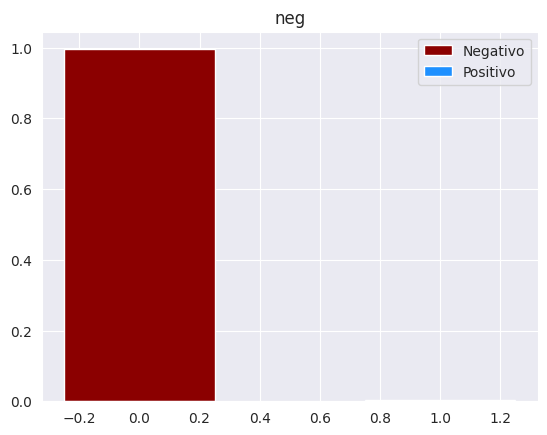

['I', 'was', 'unsure', 'of', 'this', 'movie', 'before', 'renting', 'and', 'did', 'so', 'on', 'the', 'assurance', 'that', 'Hilary', 'Swank', 'has', 'always', 'given', 'excellent', 'performances', 'in', 'her', 'movies', '.', 'She', 'seems', 'to', 'rely', 'on', 'restraint', 'to', 'gain', 'the', 'emotional', 'impact', 'that', 'she', 'does', '.', 'And', 'she', 'did', "n't", 'prove', 'me', 'wrong', 'in', 'this', 'movie.<br', '/><br', '/>However', 'the', 'movie', 'also', 'had', 'fantastic', 'performances', 'from', 'all', 'other', 'members', 'of', 'the', 'cast', 'both', 'speaking', 'and', 'non', '-', 'speaking', '.', 'I', 'have', 'to', 'single', 'out', 'Jamie', 'Bartlett', 'and', 'Chiwetel', 'Ejiofor', '-', 'the', 'two', 'main', 'protagonists', '-', 'for', 'their', 'outstanding', 'acting', 'abilities', 'and', 'portrayal', 'of', 'true', 'human', 'feelings', 'and', 'failings', '.', 'The', 'whole', 'movie', 'ran', 'almost', 'like', 'a', 'documentary.<br', '/><br', '/>I', 'must', 'applaud', 'Tom',

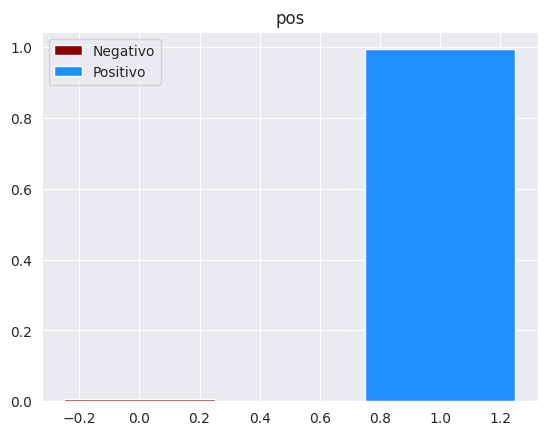

['I', "'", 'm', 'a', 'fan', 'of', 'Zhang', 'Yimou', 'and', 'finally', 'found', 'this', 'DVD', 'title', 'from', 'the', 'shelves', 'of', 'a', 'Shenzhen', 'bookstore', 'after', 'a', 'long', 'search', 'at', 'many', 'places.<br', '/><br', '/>This', 'is', 'a', 'huge', 'departure', 'from', 'previous', 'Zhang', 'Yimou', 'work', ',', 'esp', 'in', 'terms', 'of', 'style', 'and', 'locale', '.', 'The', 'director', 'himself', 'has', 'said', 'that', 'this', 'is', 'the', 'first', 'and', 'only', 'time', 'he', "'ll", 'ever', 'attempt', 'to', 'make', 'a', 'black', 'comedy', 'set', 'in', 'contemporary', 'China', '.', 'You', 'may', 'even', 'say', 'this', 'work', 'is', 'experimental', 'in', 'nature', ',', 'compared', 'to', 'his', 'other', 'well', 'known', 'big', 'budget', 'and', 'formal', 'pieces.<br', '/><br', '/>Filmed', 'with', 'a', 'hand', '-', 'held', 'camera', 'and', 'wide', 'angle', 'lens', 'throughout', 'the', 'duration', 'of', 'the', 'whole', 'film', ',', 'the', 'quick', 'pace', 'editing', 'and', '

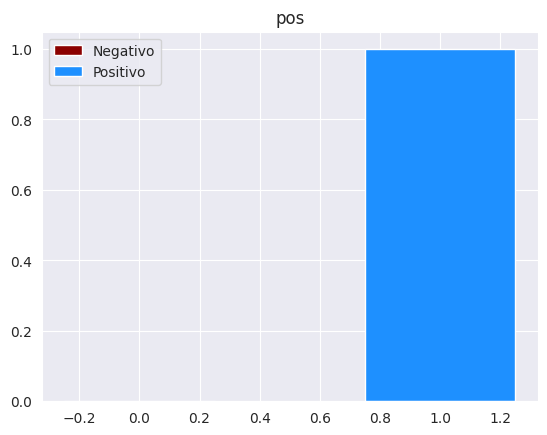

['Lazy', 'movie', 'made', 'by', 'a', 'lazy', 'director', '.', 'The', 'characters', 'are', 'grotesque', '.', 'Despite', 'the', 'tragic', 'of', 'this', 'war', ',', 'there', 'is', 'no', 'emotion', 'at', 'all', 'in', 'the', 'movie', '.', 'Symbolism', 'is', 'artificial', 'and', 'inefficient', '(', 'and', 'old', 'Bosnian', 'woman', 'giving', 'a', 'photo', 'of', 'her', 'son', 'to', 'Arbour', 'will', '"', 'concretize', '"', 'her', 'willingness', ',', 'will', 'awake', 'the', 'super', '-', 'mother', 'sleeping', 'inside', 'her', ',', 'a', 'corpse', 'eaten', 'by', 'worms', 'to', 'show', 'the', 'horror', 'of', 'genocide', '...', 'too', 'much', 'is', 'sometimes', 'worst', 'than', 'not', 'enough).<br', '/><br', '/>This', 'movie', 'is', 'only', 'an', 'advertisement', ',', 'an', 'empty', 'elegy', 'to', 'a', 'woman', 'who', 'is', 'not', 'a', 'hero', '.', 'She', 'worked', 'for', 'United', 'Nations', '.', 'Remember', 'UN', 'failed', 'to', 'protect', 'civilians', 'at', 'Srebrenica', '.', 'Who', 'are', 'the

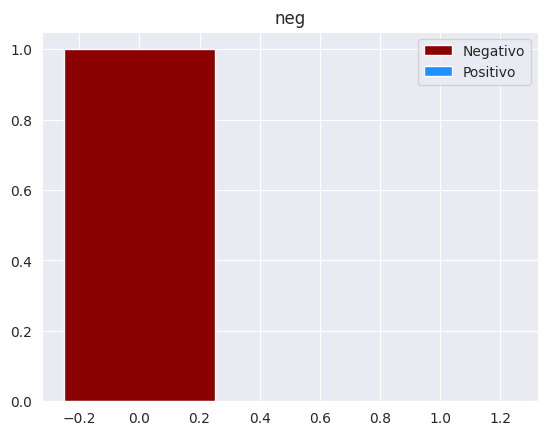

In [17]:
np.random.seed(42)
for i in range(5):
  idx = np.random.choice(len(test_data))
  text = test_data[idx].text 
  pred = predict_sentiment(' '.join(text) )

  plt.bar(0, pred[0], color='darkred', label='Negativo', width=0.5)
  plt.bar(1, pred[1], color='dodgerblue', label='Positivo', width=0.5)
  plt.title(str(test_data[idx].label))
  plt.legend()
  plt.show()